# Analyse pixelated potential reconstructions

__last update__: 11/02/22

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
from tqdm import tqdm
import numpy as np
import pickle as pkl
import corner
import seaborn as sns # for nicer colors on the plot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
plt.rc('image', interpolation='none')

from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Util import grf_util

In [2]:
SAVE_FIGURES = True

# Factor of pixel scale for the potential grid
potential_pixel_scale = 4

# What results (stored in fits files) do consider
choices = [
    ('dark halo', f'sumplot-dark_halo-scale_{potential_pixel_scale}-smooth_source.pkl'),
    ('discyness', f'sumplot-discyness-scale_{potential_pixel_scale}-smooth_source.pkl'),
    ('GRF', f'sumplot-GRF-scale_{potential_pixel_scale}-smooth_source.pkl'),
]

norm_grf_input = 2025.7998437138235

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
grid = PixelGrid(nx=npix, ny=npix, ra_at_xy_0=ra_at_xy_0, dec_at_xy_0=dec_at_xy_0,
                 transform_pix2angle=transform_pix2angle)

x_grid, y_grid = grid.pixel_coordinates

grid.create_model_grid(pixel_scale_factor=potential_pixel_scale, 
                       conserve_extent=True, name='fit')
x_grid_fit, y_grid_fit = grid.model_pixel_coordinates('fit')

extent = grid.extent

In [4]:
def get_maps(choice):
    res_label, filename = choice
    
    with open(os.path.join('results', filename), 'rb') as f:
        content = pkl.load(f)
        pixpot_model = content[2]['kwargs_lens'][-1]['pixels']
        pixpot_model_error = np.sqrt(np.abs(content[9])).reshape(*pixpot_model.shape)
        pixpot_truth_highres = content[6]
        pixpot_truth_fitgrid = content[7]
        pixpot_noise_map = content[5]
        mask_fitgrid = content[4]
    return [pixpot_model, pixpot_truth_fitgrid, 
            pixpot_truth_highres, mask_fitgrid, 
            pixpot_noise_map, pixpot_model_error]

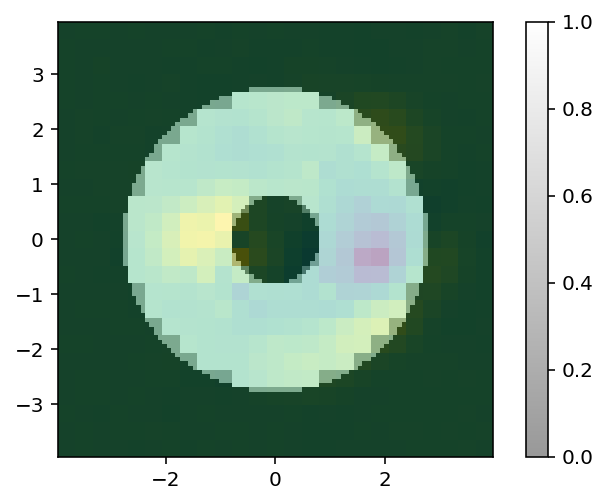

In [5]:
def annulus_mask(xx, yy, rmin, rmax):
    radius = np.hypot(xx, yy)
    mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)
    return mask

r_min = 0.8
r_max = 2.8
mask_fit = annulus_mask(x_grid_fit, y_grid_fit, r_min, r_max)
mask = annulus_mask(x_grid, y_grid, r_min, r_max)

maps_test = get_maps(choices[0])
plt.imshow(maps_test[0], origin='lower', extent=extent, alpha=1)
plt.imshow(mask_fit, origin='lower', extent=extent, alpha=0.4, cmap='gray')
plt.imshow(mask, origin='lower', extent=extent, alpha=0.4, cmap='gray')
plt.colorbar()
plt.show()

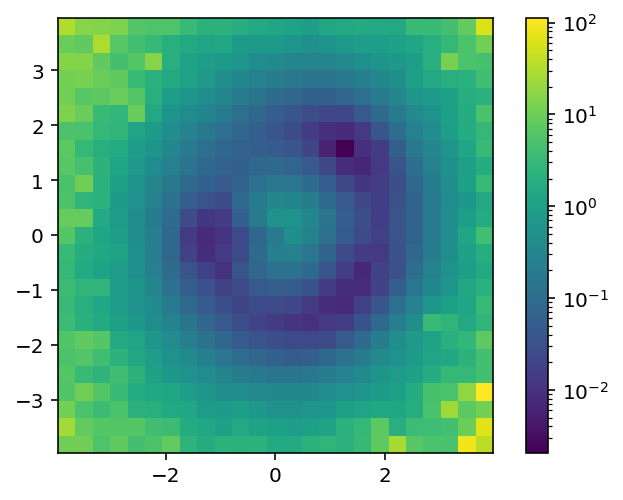

In [6]:
plt.imshow(maps_test[-1], origin='lower', extent=extent, alpha=1, norm=LogNorm())
plt.colorbar()
plt.show()

## Power spectrum analysis

In [7]:
def azimuthal_average(xx, yy, image, mask_image=None):
    if mask_image is None:
        mask_image = np.ones_like(image)
        
    # setup the radial bins
    x = xx[0, :]
    npix = len(x)
    r = x[npix//2:]
    r_step = r[1] - r[0]
    r_bin_centers = r[:-1] + r_step/2.
    
    # function that computes the mean inside an annulus
    rr = np.hypot(xx, yy)
    image_m = image * mask_image
    mean_in_annulus = lambda R: image_m[(rr >= R-r_step/2.) & (rr < R+r_step/2.)].mean()
    
    # evaluate it over a range of radii
    radii = r_bin_centers[1:]  # ignore the very central annulus because of there is drop in power (numerics?)
    average = np.vectorize(mean_in_annulus)(radii)
    return radii, average

def power_spectrum(xx, yy, image, mask_image=None):
    """
    Computes the azimuthally averaged power spectrum of an image.
    """
    if mask_image is None:
        mask_image = np.ones_like(image)
    
    # get number of pixels and pixel size 
    npix_x, npix_y = xx.shape
    pix_size = np.abs(xx[0, 0] - xx[0, 1])  # assumes square pixels
        
    # squared magnitude of FFT
    image_norm = image * pix_size**2
    fft_abs2 = np.abs(np.fft.fft2(image_norm * mask_image))**2
    
    # shift FFT image so that small wave numbers are at the center
    fft_abs2 = np.fft.fftshift(fft_abs2)
    
    # get radial bins
    k_x = np.fft.fftshift(np.fft.fftfreq(npix_x, pix_size))
    k_y = np.fft.fftshift(np.fft.fftfreq(npix_y, pix_size))
    k_xx, k_yy = np.meshgrid(k_x, k_y)
    
    # azimuthal average
    radii, ps_average = azimuthal_average(k_xx, k_yy, fft_abs2)
    
    return radii, ps_average

#print(power_spectrum(x_grid_fit, y_grid_fit, maps_test[0]))
#print(power_spectrum(x_grid, y_grid, maps_test[2]))

#plt.figure()
#plt.imshow(power_spectrum(arrays[0][1])[1], origin='lower')
#plt.show()

In [8]:
def ps_linear_fit(xx, yy, image, mask_image=None):
    k, ps = power_spectrum(xx, yy, image, mask_image=mask_image)
    x = np.log10(k)
    y = np.log10(ps)
    p, cov = np.polyfit(x, y, deg=1, cov=True)
    slope, intercept = float(p[0]), float(p[1])
    slope_err = np.sqrt(np.abs(float(cov[0, 0])))
    intercept_err = np.sqrt(np.abs(float(cov[1, 1])))
    fit = 10**intercept * k**slope
    
    # normaliazation such that when feeding the input image we get back correct variance
    var_truth = 1.00e-03
    var_input_image = 1.765e-04
    norm_grf = var_input_image / var_truth
    
    #norm_grf = norm_grf_input
    #print(norm_grf)
    
    #norm_grf = grf_util.grf_normalization(npix, npix, npix*pix_scl, npix*pix_scl, slope)
    #print(norm_grf)
    #
    #npix_fit = image.shape[0]
    #pix_scl_fit = pix_scl if image.shape[0] == npix else pix_scl * potential_pixel_scale
    #norm_grf = grf_util.grf_normalization(npix_fit, npix_fit, npix_fit*pix_scl_fit, npix_fit*pix_scl_fit, slope)
    #print(norm_grf)
    #
    #k_x = np.fft.fftshift(np.fft.fftfreq(npix, pix_scl))
    #k_y = np.fft.fftshift(np.fft.fftfreq(npix, pix_scl))
    #k_xx, k_yy = np.meshgrid(k_x, k_y)
    #Psum = np.sum((mask*np.hypot(k_xx, k_yy))**slope)
    #norm_grf = (npix**2.)/(2.*Psum)
    #print(norm_grf)
    
    var_grf = 10**intercept / norm_grf
    var_grf_err = np.log(10) * var_grf * (intercept_err/norm_grf)  # error propagation
    beta_grf = - slope
    beta_grf_err = slope_err
    
    return k, fit, (var_grf, var_grf_err), (beta_grf, beta_grf_err)

GRF params for 'groundtruth': var=1.000e-03 +/- 0.000e+00, beta=4.00 +/- 0.00
GRF params for 'input (high-res, entire FoV)': var=1.000e-03 +/- 1.773e-04, beta=4.04 +/- 0.03
GRF params for 'input (in mask)': var=1.214e-03 +/- 6.838e-04, beta=3.31 +/- 0.14
GRF params for 'model (in mask)': var=3.930e-04 +/- 3.720e-04, beta=3.37 +/- 0.23


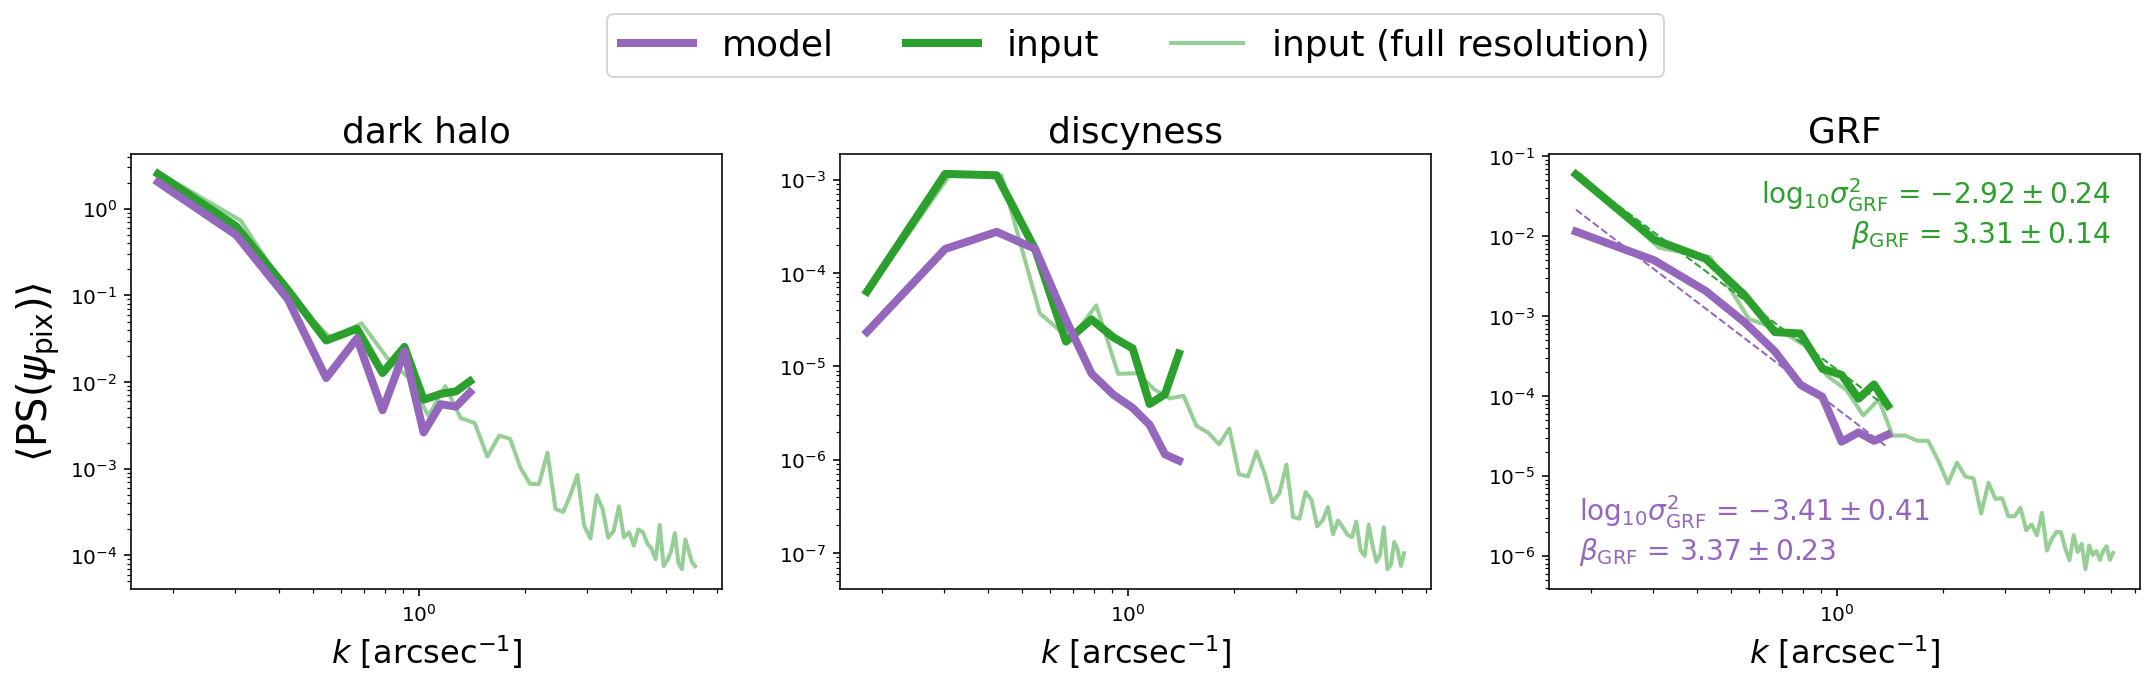

In [27]:
def print_grf_fit_results(var_tuple, beta_tuple, name):
    print(f"GRF params for '{name}': var={var_tuple[0]:.3e} +/- {var_tuple[1]:.3e}, beta={beta_tuple[0]:.2f} +/- {beta_tuple[1]:.2f}")

def fit_text(var_tuple, beta_tuple):
    logvar, beta = np.log10(var_tuple[0]), beta_tuple[0]
    logvar_err = 1./(var_tuple[0]*np.log(10)) * var_tuple[1]  # error propagation
    beta_err = beta_tuple[1]
    return r"$\log_{10}\sigma^2_{\rm GRF}$ = "+f"${logvar:.2f}\pm{logvar_err:.2f}$"+"\n"+r"$\beta_{\rm GRF}$ = "+f"${beta:.2f}\pm{beta_err:.2f}$"

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes = axes.flatten()
for i, choice in enumerate(choices):
    maps = get_maps(choice)
    model, input_fit, input_highres = maps[:3]

    ax = axes[i]
    ax.set_title(choice[0], fontsize=18)
    
    # power spectra for input potentials
    ax.plot(*power_spectrum(x_grid, y_grid, input_highres, mask_image=mask), 
            label="input (full resolution)", color='tab:green', alpha=0.5, linestyle='-', linewidth=2)
    ax.plot(*power_spectrum(x_grid_fit, y_grid_fit, input_fit, mask_image=mask_fit), 
            label="input", color='tab:green', linestyle='-', linewidth=4)
    
    # power spectra for model
    r, ps = power_spectrum(x_grid_fit, y_grid_fit, model, mask_image=mask_fit)
    ax.plot(r, ps, label="model", color='tab:purple', linestyle='-', linewidth=4)
    
    # with error bars
    #ps_err = ps_error_list[:, i]
    #ps_err_up = np.zeros((2, len(ps_err)))
    #ps_err_up[1, :] = ps_err  # this is for removing lower error bars (do not look good on logscale)
    #ax.errorbar(r, ps, yerr=ps_err_up, label="model", zorder=100,
    #            elinewidth=2, ecolor='tab:purple', 
    #            color='tab:purple', linestyle='-', linewidth=4)
    
    # linear fits (for GRF)
    if 'GRF' in choice:
        x, y, var_grf_input, beta_grf_input = ps_linear_fit(x_grid_fit, y_grid_fit, input_fit, mask_image=mask_fit)
        ax.plot(x, y, color='tab:green', alpha=1, linestyle='--', linewidth=1)
        x, y, var_grf_model, beta_grf_model = ps_linear_fit(x_grid_fit, y_grid_fit, model, mask_image=mask_fit)
        ax.plot(x, y, color='tab:purple', alpha=1, linestyle='--', linewidth=1)
        
        x, y, var_grf_input_hr, beta_grf_input_hr = ps_linear_fit(x_grid, y_grid, input_highres, mask_image=None)
        #ax.plot(x, y, color='black', alpha=0.5, linestyle=':', linewidth=2)
        
        var_grf_truth, beta_grf_truth = (1e-3, 0), (4, 0)
        print_grf_fit_results(var_grf_truth, beta_grf_truth, "groundtruth")
        print_grf_fit_results(var_grf_input_hr, beta_grf_input_hr, "input (high-res, entire FoV)")
        print_grf_fit_results(var_grf_input, beta_grf_input, "input (in mask)")
        print_grf_fit_results(var_grf_model, beta_grf_model, "model (in mask)")
        
        ax.text(0.05, 0.05, fit_text(var_grf_model, beta_grf_model), 
                fontsize=14, color='tab:purple', 
                ha='left', va='bottom', transform=ax.transAxes)
        ax.text(0.95, 0.95, fit_text(var_grf_input, beta_grf_input), 
                fontsize=14, color='tab:green', 
                ha='right', va='top', transform=ax.transAxes)
  
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r"$k\ [{\rm arcsec}^{-1}]$", fontsize=16)
    if i == 0:
        ax.set_ylabel(r"$\langle {\rm PS}(\psi_{\rm pix}) \rangle$", fontsize=20)
axes[1].legend(axes[1].get_legend_handles_labels()[0][::-1],
               axes[1].get_legend_handles_labels()[1][::-1],
               bbox_to_anchor=(0.5, 1.25), loc='center', ncol=3,
               fontsize=18)
plt.show()

In [28]:
if SAVE_FIGURES:
    figure_dir = os.path.join('figures', 'power spectra')
    figure_name = 'pixpot_power_spectra.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight')

## Central moment analysis

In [11]:
from skimage import measure
from lenstronomy.Util import analysis_util

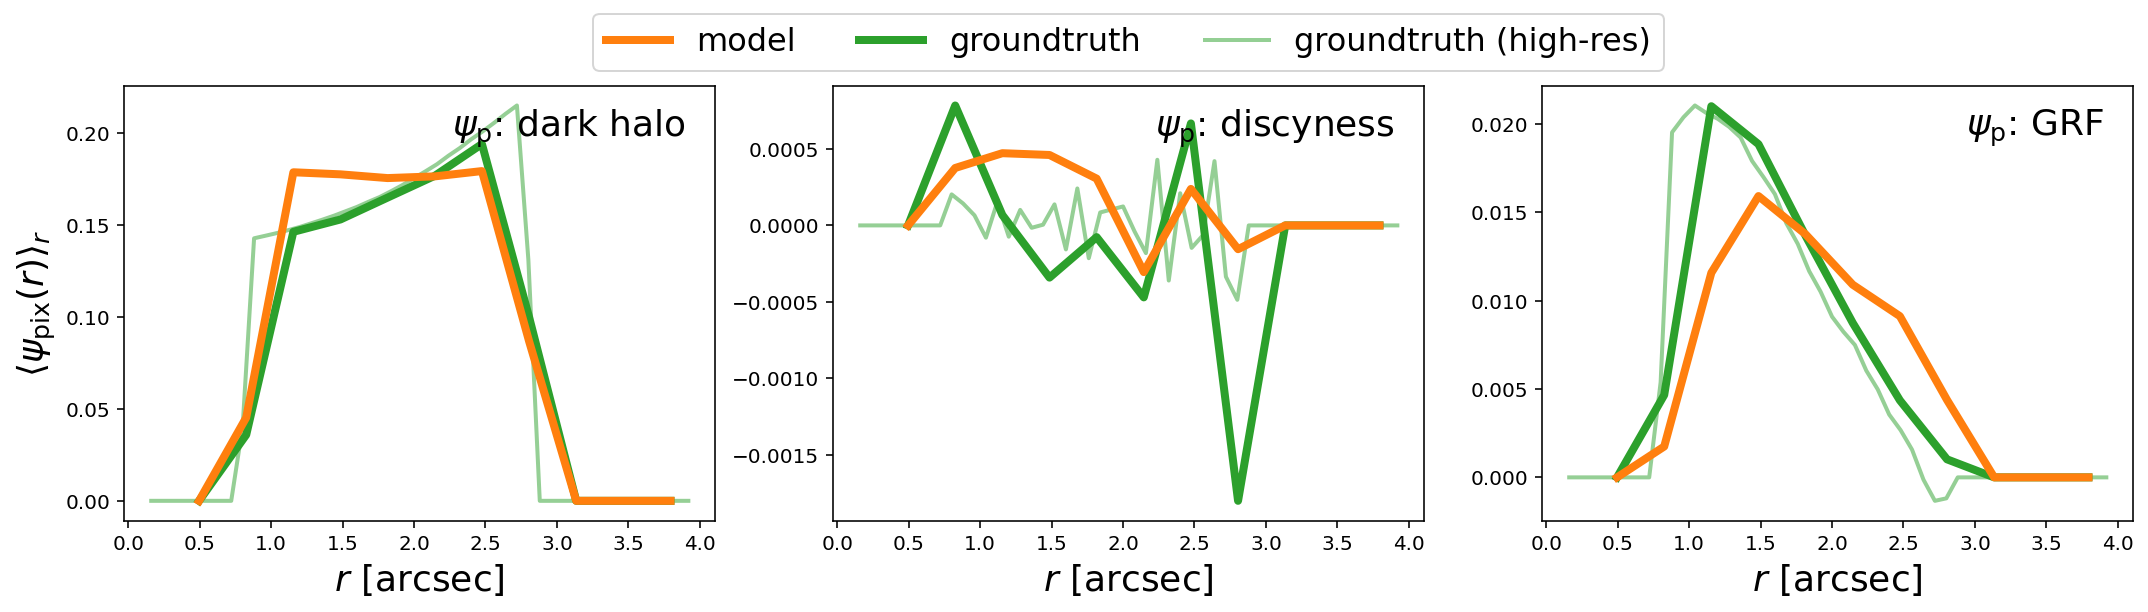

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes = axes.flatten()
for i, choice in enumerate(choices):
    maps = get_maps(choice)
    
    #fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    #im = ax.imshow(maps[2])
    #fig.colorbar(im, ax=ax)
    #plt.show()
    
    ax = axes[i]
    ax.text(0.95, 0.95, r"$\psi_{\rm p}$: " + choice[0], fontsize=18, ha='right', va='top', transform=ax.transAxes)
    
    # radial profile for input potentials
    ax.plot(*azimuthal_average(x_grid, y_grid, maps[2], mask_image=mask), 
            label="groundtruth (high-res)", color='tab:green', alpha=0.5, linestyle='-', linewidth=2)
    ax.plot(*azimuthal_average(x_grid_fit, y_grid_fit, maps[1], mask_image=mask_fit), 
            label="groundtruth", color='tab:green', linestyle='-', linewidth=4)
    
    # radial profile for model
    ax.plot(*azimuthal_average(x_grid_fit, y_grid_fit, maps[0], mask_image=mask_fit), 
            label="model", color='tab:orange', linestyle='-', linewidth=4)
    
    ax.set_xlabel(r"$r\ [{\rm arcsec}]$", fontsize=18)
    
    if i == 0:
        ax.set_ylabel(r"$\langle\psi_{\rm pix}(r)\rangle_r$", fontsize=18)
        
axes[1].legend(axes[1].get_legend_handles_labels()[0][::-1],
               axes[1].get_legend_handles_labels()[1][::-1],
               bbox_to_anchor=(0.5, 1.1), loc='center', ncol=3,
               fontsize=16)
plt.show()

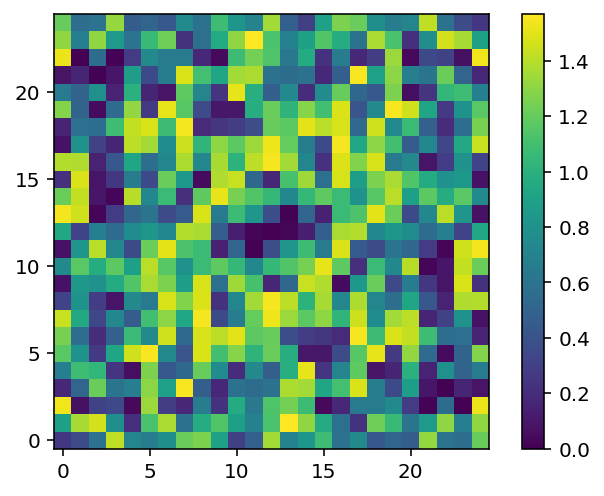

lenstronomy (7.572276482268615, 0.9402708237003468, 6.535168624008168, -0.779314034441041)
lenstronomy (6.905964915193386, -0.5919495873641225, 3.8622151875096202, -0.917476814227511)
lenstronomy (0.0, 0.0, 0.0, -0.9282048797009215)


In [13]:
from scipy import fftpack
map_test = get_maps(choices[2])
#plt.imshow(fftpack.dct(map_test[2]), origin='lower')
#fft = np.fft.fft2(map_test[2] * mask)
fft = np.fft.fftshift(np.fft.fft2(map_test[0] * mask_fit))
fft_phase = np.arctan(fft.imag/fft.real)
plt.imshow(np.abs(fft_phase), origin='lower')
plt.colorbar()
plt.show()

#print(choice[0])
print("lenstronomy", analysis_util.moments(maps[0] * mask_fit, x_grid_fit, y_grid_fit))
print("lenstronomy", analysis_util.moments(maps[1] * mask_fit, x_grid_fit, y_grid_fit))
print("lenstronomy", analysis_util.moments(maps[2] * mask, x_grid, y_grid))

#print("skimage", measure.moments_central(maps[2], order=3))